<a href="https://colab.research.google.com/github/ramajoballester/mil_deeplearning/blob/main/1_introduccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sesión 1. Introducción al Deep Learning

# Introducción

En solo los últimos cinco años, el Aprendizaje Profundo (*Deep Learning*) ha impulsado un rápido progreso en campos tan diversos como la visión por ordenador, el procesamiento del lenguaje natural, el reconocimiento automático del habla, el aprendizaje por refuerzo y la informática biomédica. Además, el éxito del aprendizaje profundo en tantas tareas de interés ha catalizado incluso desarrollos en el aprendizaje automático teórico y la estadística. Con estos avances en la mano, ahora podemos construir coches que se conducen solos con más autonomía que nunca (y menos autonomía de lo que algunas empresas podrían hacer creer), sistemas de respuesta inteligente que redactan automáticamente los correos electrónicos más mundanos y máquinas que dominan a los mejores humanos del mundo en juegos de mesa como el Go, una hazaña que antes se creía que estaba a décadas de distancia. Estas herramientas ya ejercen un impacto cada vez mayor en la industria y la sociedad, cambiando la forma de hacer películas, diagnosticar enfermedades y desempeñando un papel cada vez más importante en las ciencias básicas, desde la astrofísica hasta la biología.

## Instalación de librerías (quitar?)

In [ ]:
! pip install -q wandb
! pip install -q --upgrade albumentations
! pip install -q ipympl

     |████████████████████████████████| 102 kB 5.8 MB/s 
     |████████████████████████████████| 47.8 MB 1.4 MB/s 


In [ ]:
!pip install --upgrade -q gspread

In [ ]:
import gspread
import pandas as pd
from google.colab import auth
auth.authenticate_user()
from google.auth import default

In [ ]:
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/1rDJQgihE4bvVNGmPjT8sH5mCRrbOfNcEFf8KZoxZ870/edit?usp=sharing'
worksheet = gc.open_by_url(url)

In [ ]:
a = float(worksheet.sheet1.get('C5')[0][0])

In [ ]:
a

0.954782

In [ ]:
row = 5
col = 3
value = 0.954782
worksheet.sheet1.update_cell(row, col, value);

# Regresión lineal

## Implementación desde cero

La regresión lineal es un modelo matemático que aproxima la relación entre una o más variables independientes y una variable dependiente. En las ciencias naturales y sociales, el objetivo de la regresión suele ser caracterizar la relación entre las entradas y las salidas. El aprendizaje automático, en cambio, se ocupa más a menudo de la predicción.

Los problemas de regresión surgen siempre que queremos predecir un valor numérico. Algunos ejemplos comunes son la predicción de precios (de viviendas, acciones, etc.), la predicción de la duración de la estancia (para los pacientes en el hospital), la previsión de la demanda (para las ventas al por menor), entre otros innumerables. No todos los problemas de predicción son problemas clásicos de regresión. En los problemas de clasificación, por ejemplo, el objetivo es predecir la pertenencia a un conjunto de categorías.

Más sobre teoría detrás de reg. lineal?

In [28]:
import random
import torch
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

In [ ]:
def synthetic_data(w, b, noise, num_examples):
    """Generar y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, noise, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2.0])
true_b = 4.2
noise = 0.5
features, labels = synthetic_data(true_w, true_b, noise, 1000)

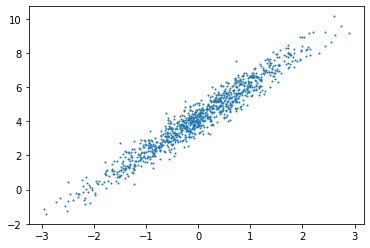

In [ ]:
plt.scatter(features[:, 0], labels, 1);

In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [ ]:
batch_size = 8

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.5878],
        [ 0.7563],
        [-0.7238],
        [-0.8571],
        [ 1.7229],
        [ 0.3907],
        [-0.9360],
        [ 0.4381]]) 
 tensor([[3.5591],
        [5.6308],
        [3.1466],
        [2.5750],
        [7.4162],
        [5.1642],
        [2.5212],
        [4.5701]])


In [ ]:
def linreg(X, w, b):
    """Modelo de regresión lineal"""
    return torch.matmul(X, w) + b

In [ ]:
def squared_loss(y_hat, y):
    """Función de pérdida Squared Loss"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [ ]:
def sgd(params, lr, batch_size):
    """Descenso de gradiente estocástico"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

$$\hat{y} = w_1  x_1 + ... + w_d  x_d + b.$$

$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$

Función de pérdida
$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\color{Salmon}{\hat{y}^{(i)}} - y^{(i)}\right)^2$$

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\color{Salmon}{\mathbf{w}^\top \mathbf{x}^{(i)} + b} - y^{(i)}\right)^2$$

Descenso de gradiente
$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\alpha}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)$$

GD para $w$
$$\mathbf{w} \leftarrow \mathbf{w} - \frac{\alpha}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) = \mathbf{w} - \frac{\alpha}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)$$

GD para $b$
$$b \leftarrow b -  \frac{\alpha}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_b l^{(i)}(\mathbf{w}, b)  = b - \frac{\alpha\\}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)$$

fit-linreg.svg

In [ ]:
w = torch.normal(0, 0.01, size=(len(true_w),1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Learning rate
lr = 0.01
# Número de epochs de entrenamiento
num_epochs = 5
# Modelo a optimizar
net = linreg
# Función de pérdida cuadrática
loss = squared_loss

w_history = [w.item()]
b_history = [b.item()]

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # Pérdida entre predicción del modelo y los valores reales y
        l = loss(net(X, w, b), y)
        # Cálculo de los gradientes (derivadas) de la función de pérdida respecto
        # de los parámetros del modelo
        l.sum().backward()
        # Actualización de los parámetros según sus gradientes
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
    
    w_history.append(w.item())
    b_history.append(b.item())

epoch 1, loss 1.014814
epoch 2, loss 0.205985
epoch 3, loss 0.136863
epoch 4, loss 0.131104
epoch 5, loss 0.130611


In [ ]:
print('Error de estimación w: {}'.format(true_w - w.reshape(true_w.shape)))
print('Error de estimación b: {}'.format(true_b - b))

Error de estimación w: tensor([-0.0088], grad_fn=<SubBackward0>)
Error de estimación b: tensor([-0.0012], grad_fn=<RsubBackward1>)


In [ ]:
print(w)
print(true_w)

tensor([[2.0088]], requires_grad=True)
tensor([2.])


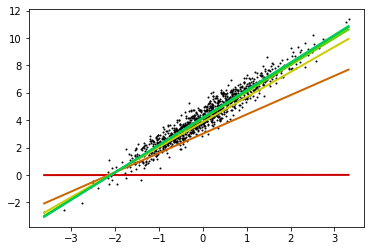

In [ ]:
x1 = min(features[:, 0])
x2 = max(features[:, 0])
fig = plt.figure()
plt.scatter(features[:, 0], labels, 1, color='k');
for i in range(len(w_history)):
    y1, y2 = (w_history[i] * torch.Tensor([[x1], [x2]]) + b_history[i]).detach().numpy()
    plt.plot([x1, x2], [y1, y2], color=hsv_to_rgb((0.5*(i/len(w_history)), 1, 0.8)), linewidth=2);

## Implementación en Pytorch

In [ ]:
import torch.nn.functional as F
from torch import nn

In [ ]:
true_w = torch.tensor([2.0])
true_b = 4.2
noise = 0.5
features, labels = synthetic_data(true_w, true_b, noise, 1000)

dataset = torch.utils.data.TensorDataset(features, labels)
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

In [ ]:
class LinReg(nn.Module):
    '''
    Modelo de regresión lineal
    '''
    def __init__(self):
        super(LinReg, self).__init__()
        self.linear = nn.Linear(1, 1)
        
    def forward(self, x):
        out = self.linear(x)
        return out

In [ ]:
model = LinReg()

In [ ]:
# Batch size
batch_size = 8
# Learning rate
lr = 0.005
# Número de epochs de entrenamiento
num_epochs = 5

In [ ]:
# Función de pérdida
loss = nn.MSELoss()
# Optimizador
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [ ]:
# Inicialización de los parámetros
model.linear.weight.data.normal_(0, 0.01)
model.linear.bias.data.fill_(0)

for epoch in range(num_epochs):
    for X, y in dataloader:
        l = loss(model(X) ,y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    l = loss(model(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 2.054285
epoch 2, loss 0.401637
epoch 3, loss 0.266662
epoch 4, loss 0.255188
epoch 5, loss 0.254660


In [ ]:
model.linear.weight

Parameter containing:
tensor([[1.9924]], requires_grad=True)

In [ ]:
model.linear.bias

Parameter containing:
tensor([4.2261], requires_grad=True)

## Añadir trabajo individual?

# Regresión softmax

In [29]:
import torchvision

In [30]:
# "ToTensor" convierte las imágenes de tipo PIL a float32
# y divide el resultado entre 255 para restringirlas al rango [0, 1]

image_size = 32

transf = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((image_size, image_size))
])
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=transf, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=transf, download=True)

In [31]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [32]:
labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
          'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [33]:
batch_size = 256
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size,
                                               shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size,
                                               shuffle=False, num_workers=1)

$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o})\quad \text{donde}\quad \hat{y}_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}. $$


$$
\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j.
$$

In [ ]:
def softmax(X):
    X_exp = torch.exp(X)
    return X_exp / X_exp.sum(1, keepdim=True)

The softmax function gives us a vector $\hat{\mathbf{y}}$,
which we can interpret as estimated conditional probabilities
of each class given any input $\mathbf{x}$, e.g.,
$\hat{y}_1$ = $P(y=\text{cat} \mid \mathbf{x})$.
Suppose that the entire dataset $\{\mathbf{X}, \mathbf{Y}\}$ has $n$ examples,
where the example indexed by $i$
consists of a feature vector $\mathbf{x}^{(i)}$ and a one-hot label vector $\mathbf{y}^{(i)}$.
We can compare the estimates with reality
by checking how probable the actual classes are
according to our model, given the features:

$$
P(\mathbf{Y} \mid \mathbf{X}) = \prod_{i=1}^n P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)}).
$$

According to maximum likelihood estimation,
we maximize $P(\mathbf{Y} \mid \mathbf{X})$,
which is
equivalent to minimizing the negative log-likelihood:

$$
-\log P(\mathbf{Y} \mid \mathbf{X}) = \sum_{i=1}^n -\log P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)})
= \sum_{i=1}^n l(\mathbf{y}^{(i)}, \hat{\mathbf{y}}^{(i)}),
$$

where for any pair of label $\mathbf{y}$ and model prediction $\hat{\mathbf{y}}$ over $q$ classes,
the loss function $l$ is

$$ l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j. $$

## Read CSV

In [ ]:
import pandas as pd

In [ ]:
df_train = pd.read_csv('/content/sample_data/california_housing_train.csv')